# MODELING

## PROBLEM DEFINITION AND GOALS

**We aim to model, predict, and simulate foreign aid dynamics for Kenya.**  

### CORE MODELING OBJECTIVES

1. **Aid Flow Stability And Volatility Analysis**  
   - Goal: Identify which sectors, agencies, and partners are most stable, volatile, or dominant in aid delivery.  
   - Approach:  
     - Compute volatility metrics (rolling std, coefficient of variation).  
     - Classify entities using unsupervised clustering or ranking.  
     - Highlight dominant vs. emerging actors.

2. **Predictive And Scenario Forecasting**  
   - Goal: Predict future funding flows or simulate policy shocks (e.g., “25% cut in USAID funding”).  
   - Approach: 
     - Use regression models (XGBoost, Random Forest, Prophet) on aid totals.  
     - Simulate counterfactual scenarios by adjusting model inputs.

3. **Temporal Forecasting And Shock Simulation**  
   - Goal: Model aid trends across fiscal years and assess resilience to fiscal shocks.  
   - Approach:  
     - Time series forecasting (Prophet, ARIMA, LSTM).  
     - Introduce synthetic shocks to test system response.

4. **Sectoral Dependency Clustering**  
   - Goal: Cluster sectors by their dependency on foreign aid.  
   - Approach:  
     - Use KMeans, DBSCAN, or hierarchical clustering.  
     - Base features on aid ratios and concentration metrics.

## DATA AUDIT

### STRONG COLUMNS
Provide robust quantitative and categorical anchors:
- Temporal: fiscal_year, transaction_date, year, quarter
- Categorical Context: country_name, us_sector_name, us_category_name
- Management Context: managing_subagency_or_bureau_name, funded_and_managed_by, dominant_sector_per_agency
- Monetary & Variability Indicators:  
  current_dollar_amount, constant_dollar_amount, total_aid_fiscal,  
  aid_volatility, rolling_mean_3yr, rolling_std_3yr, aid_concentration_index,  
  top3_agency_share, sector_to_total_ratio, agency_to_total_ratio,  
  aid_per_partner, relative_aid_share, aid_std_fiscal,  
  mean_aid_per_transaction_fiscal

### COLUMNS THAT NEED ATTENTION
- objective, transaction_type_name -> will need grouping or encoding.  
- transaction_lag, transaction_lead -> align correctly with fiscal years.    

### COLUMNS TO DROP
- transaction_date -> replace with derived temporal features.  
- country_name -> constant for Kenya, can be dropped.  
- Columns ending in _interaction -> use dimensionality reduction (PCA) or selective inclusion.

## WORKFLOW

### DATA PREPARATION
1. Handle missingness with appropriate imputations.  
2. Normalize skewed monetary variables (we will use log1p).  
3. Encode categorical variables using **target encoding** or **frequency encoding**.  
4. Aggregate aid data by **year**, **sector**, or **agency** depending on the model goal.  
5. Split data chronologically (e.g train up to 2019, test from 2020 onward).

### FEATURE ENGINEERING CONSIDERATIONS
- Rolling averages: rolling_mean_3yr, rolling_std_3yr, sector_growth_rate, agency_growth_rate
- Concentration & diversity: aid_concentration_index, aid_diversity_index
- Ratios: sector_to_total_ratio, agency_to_total_ratio
- Interaction terms: agency_sector_interaction, partner_agency_interaction

### TARGET PICKING

| Objective | Problem Type | Model Candidates | Key Targets |
|------------|---------------|------------------|--------------|
| **Stability & Volatility** | Unsupervised / Ranking | KMeans, Isolation Forest, PCA, TS Clustering | aid_volatility, aid_concentration_index |
| **Predictive Forecasting** | Supervised Regression | XGBoost, LightGBM, Prophet | total_aid_fiscal, constant_dollar_amount |
| **Temporal Forecasting** | Time Series | Prophet, ARIMA, LSTM | total_aid_fiscal, sector_to_total_ratio |
| **Sector Dependency** | Clustering | KMeans, Spectral, DBSCAN | sector_to_total_ratio, aid_per_partner, aid_concentration_index |

### EVALUATION METRICS
- **Regression Models:** RMSE, MAE, MAPE, R²  
- **Forecasting Models:** MAPE, RMSE, Directional Accuracy  
- **Clustering Models:** Silhouette Score, Calinski-Harabasz Index  
- **Volatility Analysis:** Rolling std comparison, stability ranking

### SCENARIO SIMULATION
Run post-model scenario experiments:
- Introduce a **shock factor**, e.g., USAID_cut = -0.25  
- Recompute predicted totals and compare to baseline.  
- Measure cascading impacts by sector (sector_to_total_ratio shifts).  
- Visualize using waterfall charts or delta bar plots.

### VISUALS
- **Time Series:** Aid trends per sector/agency.  
- **Heatmaps:** Volatility or concentration over time.  
- **Cluster Maps:** Sector dependency visualization.  
- **Scenario Dashboards:** Policy or funding cut simulations.

In [ ]:
# ------- [Import all relevant libraries] -------

# General Utilities
import warnings
warnings.filterwarnings('ignore')

import numpy as np                          # Numerical computing
import pandas as pd                         # Data manipulation and analysis
import datetime as dt                       # Date/time operations
import re                                   # String manipulation
from collections import Counter             # Frequency counting
import logging
import math
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# Statistics
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Feature Engineering & Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler,
    RobustScaler
)
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, GridSearchCV, StratifiedKFold
)
from sklearn.decomposition import PCA, TruncatedSVD

# Machine Learning Models
# ======================

## Supervised Learning (Regression/Prediction)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

## Unsupervised Learning (Volatility and Dependency Clustering)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Time Series & Forecasting
from statsmodels.tsa.arima.model import ARIMA
# !pip install prophet
from prophet import Prophet

# Evaluation Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, calinski_harabasz_score,
    davies_bouldin_score
)

# # Imbalanced Data Handling
# from imblearn.over_sampling import SMOTE

# Model Interpretation & Explainability
# !pip install eli5
from lime import lime_tabular

# Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display

In [37]:
# Load modeling dataset
df = pd.read_csv("../Clean Data/clean_data.csv")

# Drop country_name
df.drop(columns=['country_name'], inplace=True)

In [38]:
df.columns

Index(['managing_subagency_or_bureau_name', 'us_category_name',
       'us_sector_name', 'objective', 'transaction_type_name', 'fiscal_year',
       'transaction_date', 'current_dollar_amount', 'constant_dollar_amount',
       'transaction_year', 'transaction_month', 'transaction_quarter',
       'is_end_of_fiscal_year', 'days_since_start_of_year',
       'is_holiday_quarter', 'aid_volatility', 'rolling_mean_3yr',
       'rolling_std_3yr', 'total_aid_fiscal', 'transaction_count_fiscal',
       'mean_aid_per_transaction_fiscal', 'aid_std_fiscal', 'total_sector_aid',
       'avg_sector_aid', 'sector_transaction_count', 'total_agency_aid',
       'avg_agency_aid', 'agency_transaction_count', 'total_partner_aid',
       'partner_transaction_count', 'sector_to_total_ratio',
       'agency_to_total_ratio', 'transaction_lag', 'transaction_lead',
       'sector_growth_rate', 'agency_growth_rate', 'partner_growth_rate',
       'agency_count_fiscal', 'aid_concentration_index', 'top3_agency_share

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68264 entries, 0 to 68263
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   managing_subagency_or_bureau_name  68264 non-null  object 
 1   us_category_name                   68264 non-null  object 
 2   us_sector_name                     68264 non-null  object 
 3   objective                          68264 non-null  object 
 4   transaction_type_name              68264 non-null  object 
 5   fiscal_year                        68264 non-null  int64  
 6   transaction_date                   68264 non-null  object 
 7   current_dollar_amount              68264 non-null  float64
 8   constant_dollar_amount             68264 non-null  float64
 9   transaction_year                   68264 non-null  int64  
 10  transaction_month                  68264 non-null  int64  
 11  transaction_quarter                68264 non-null  int

## DESCRIPTIVE ANALYTICS

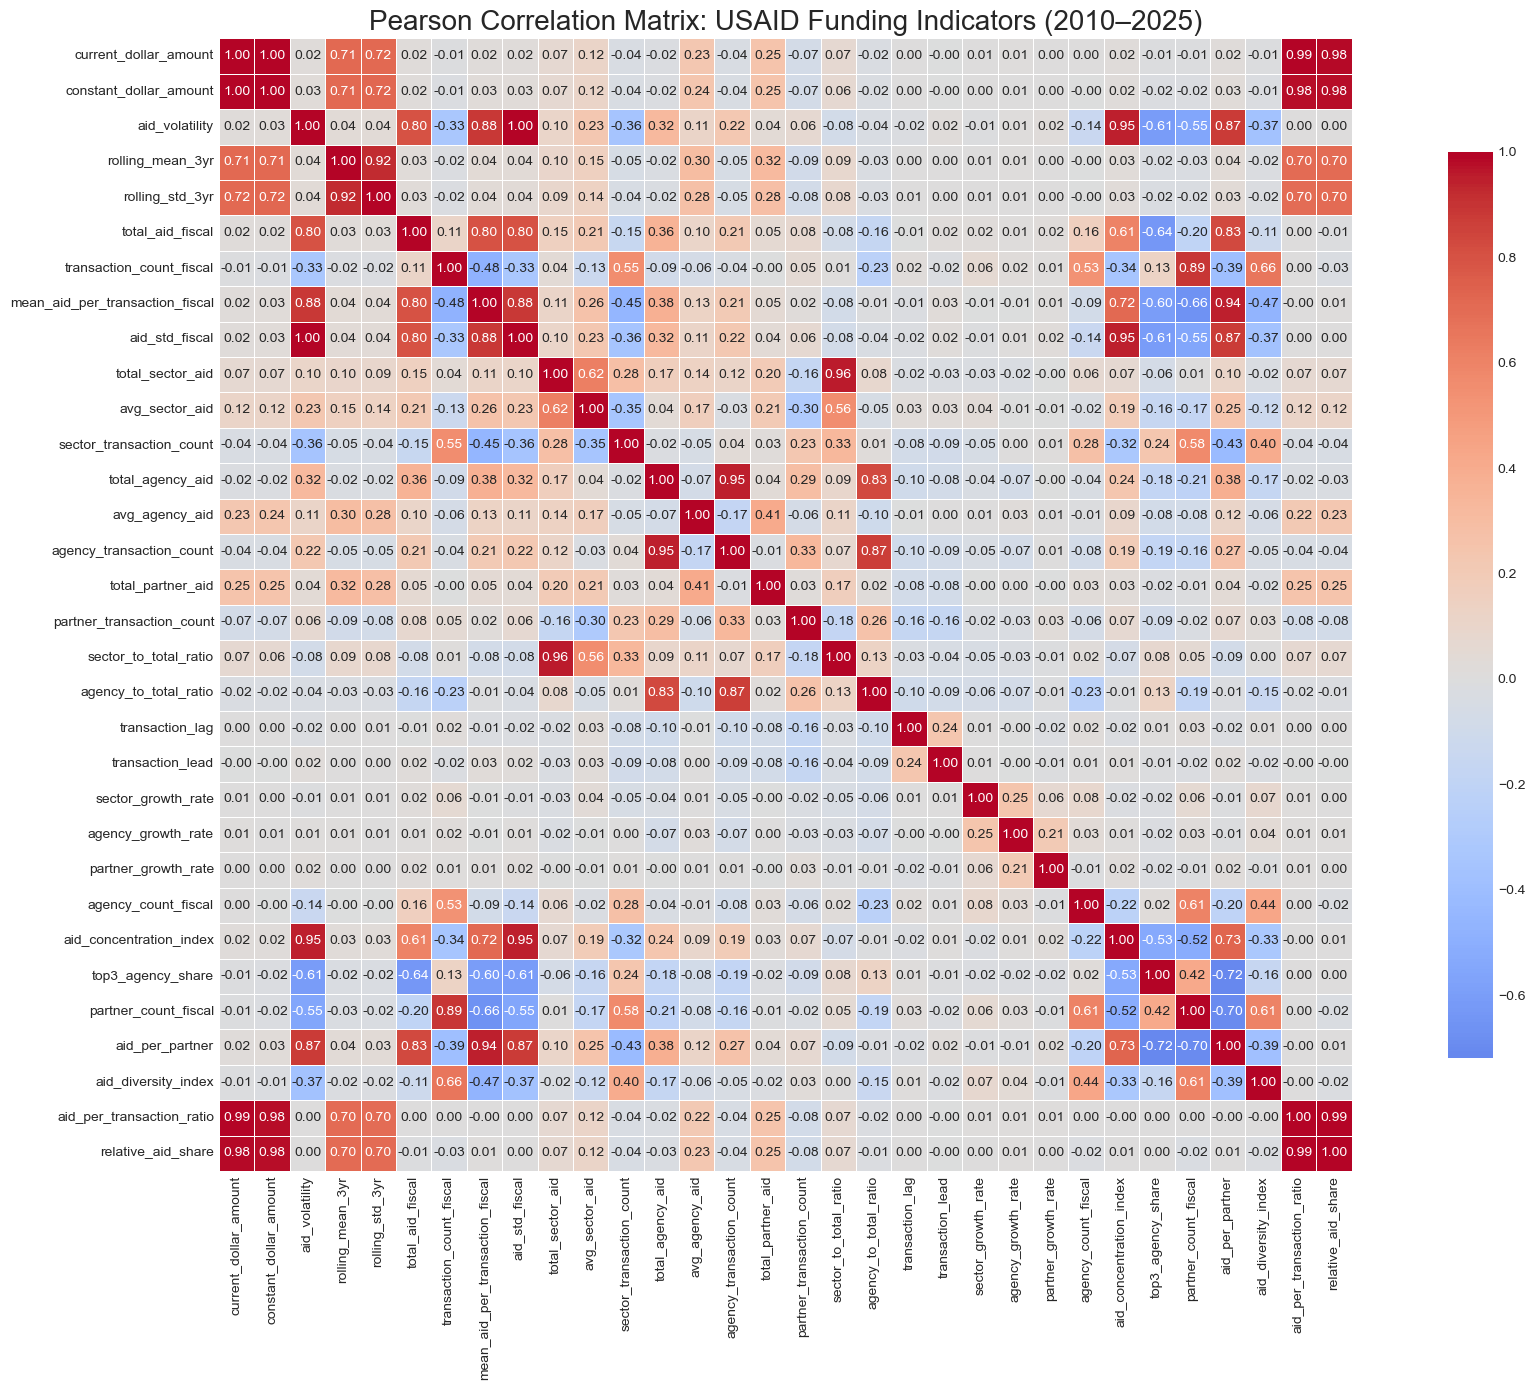

In [40]:
num_cols = [
    'current_dollar_amount', 'constant_dollar_amount', 
    'aid_volatility', 'rolling_mean_3yr', 'rolling_std_3yr',
    'total_aid_fiscal', 'transaction_count_fiscal', 
    'mean_aid_per_transaction_fiscal', 'aid_std_fiscal',
    'total_sector_aid', 'avg_sector_aid', 'sector_transaction_count',
    'total_agency_aid', 'avg_agency_aid', 'agency_transaction_count',
    'total_partner_aid', 'partner_transaction_count',
    'sector_to_total_ratio', 'agency_to_total_ratio',
    'transaction_lag', 'transaction_lead',
    'sector_growth_rate', 'agency_growth_rate', 'partner_growth_rate',
    'agency_count_fiscal', 'aid_concentration_index', 'top3_agency_share',
    'partner_count_fiscal', 'aid_per_partner', 
    'aid_diversity_index', 'aid_per_transaction_ratio',
    'relative_aid_share'
]

# Compute correlation matrix
corr = df[num_cols].corr(method='pearson')

# Visualize
plt.figure(figsize=(20, 14))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt=".2f", 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Pearson Correlation Matrix: USAID Funding Indicators (2010–2025)', fontsize=20)
plt.tight_layout()
plt.show()

In [41]:
# Flatten and sort
corr_pairs = corr.unstack().sort_values(ascending=False)
strong_pairs = corr_pairs[(abs(corr_pairs) > 0.7) & (abs(corr_pairs) < 1)]
strong_pairs.head(20)

current_dollar_amount      constant_dollar_amount       0.997202
constant_dollar_amount     current_dollar_amount        0.997202
current_dollar_amount      aid_per_transaction_ratio    0.988428
aid_per_transaction_ratio  current_dollar_amount        0.988428
                           relative_aid_share           0.987092
relative_aid_share         aid_per_transaction_ratio    0.987092
                           current_dollar_amount        0.983363
current_dollar_amount      relative_aid_share           0.983363
constant_dollar_amount     relative_aid_share           0.979736
relative_aid_share         constant_dollar_amount       0.979736
aid_per_transaction_ratio  constant_dollar_amount       0.977754
constant_dollar_amount     aid_per_transaction_ratio    0.977754
total_sector_aid           sector_to_total_ratio        0.957117
sector_to_total_ratio      total_sector_aid             0.957117
aid_volatility             aid_concentration_index      0.952477
aid_std_fiscal           

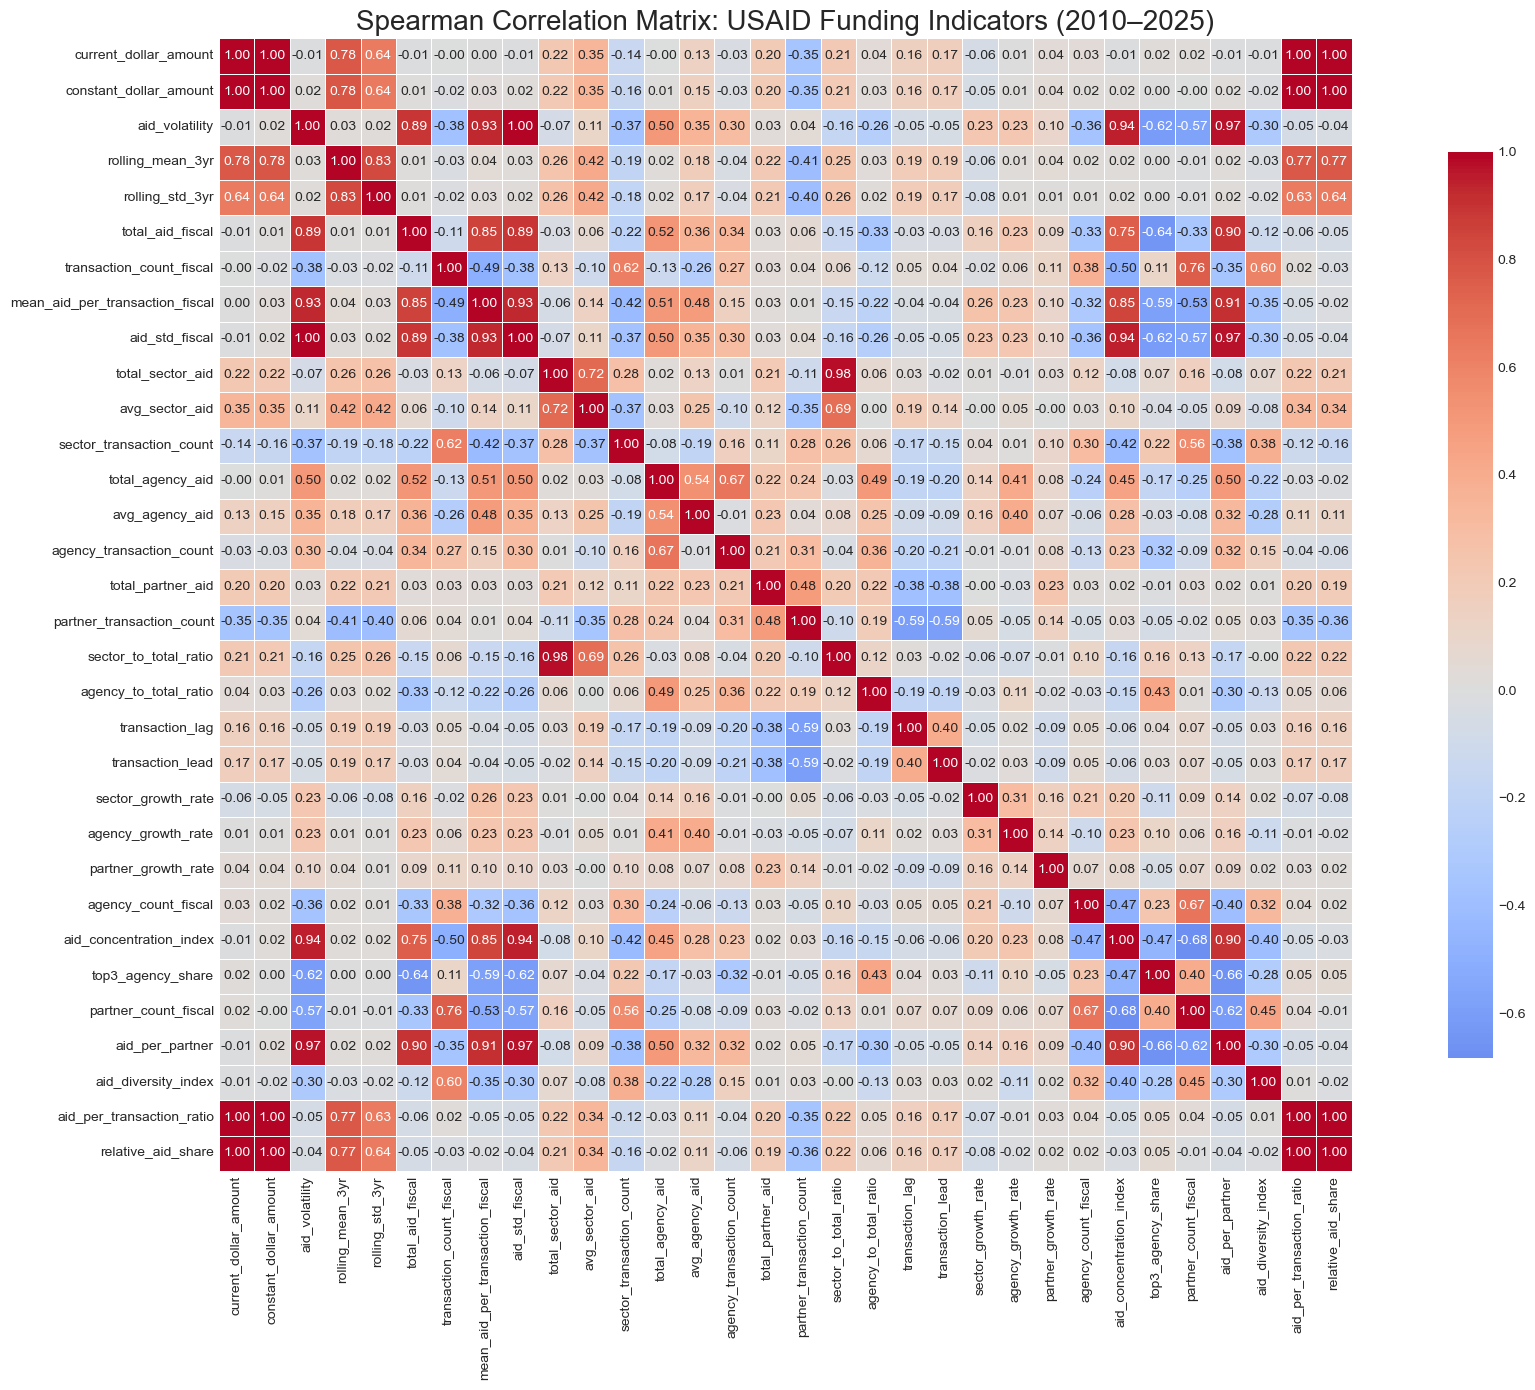

In [42]:
corr_spearman = df[num_cols].corr(method='spearman')

plt.figure(figsize=(20, 14))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True, fmt=".2f", 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Spearman Correlation Matrix: USAID Funding Indicators (2010–2025)', fontsize=20)
plt.tight_layout()
plt.show()

In [43]:
# Flatten and sort
corr_pairs = corr_spearman.unstack().sort_values(ascending=False)
strong_pairs = corr_pairs[(abs(corr_pairs) > 0.7) & (abs(corr_pairs) < 1)]
strong_pairs.head(20)

constant_dollar_amount     current_dollar_amount        0.999339
current_dollar_amount      constant_dollar_amount       0.999339
                           aid_per_transaction_ratio    0.998045
aid_per_transaction_ratio  current_dollar_amount        0.998045
relative_aid_share         aid_per_transaction_ratio    0.998003
aid_per_transaction_ratio  relative_aid_share           0.998003
relative_aid_share         current_dollar_amount        0.996947
current_dollar_amount      relative_aid_share           0.996947
relative_aid_share         constant_dollar_amount       0.995719
constant_dollar_amount     relative_aid_share           0.995719
                           aid_per_transaction_ratio    0.995630
aid_per_transaction_ratio  constant_dollar_amount       0.995630
total_sector_aid           sector_to_total_ratio        0.977103
sector_to_total_ratio      total_sector_aid             0.977103
aid_per_partner            aid_std_fiscal               0.970597
aid_volatility           

## CLUSTERING


📊 Detected Skewed Features (|skew| > 1.0):
['rolling_mean_3yr', 'rolling_std_3yr', 'sector_growth_rate', 'agency_growth_rate', 'total_sector_aid', 'sector_to_total_ratio', 'aid_per_transaction_ratio']


,k,inertia,silhouette,calinski,davies
0,2,385.840371,0.111035,1.440765,1.468121
1,3,59.504339,0.221654,23.282077,0.712012
2,4,27.330396,0.254173,31.320302,0.526376
3,5,22.351573,0.030652,24.214008,0.553608
4,6,14.634209,0.033950,24.091186,0.536404
5,7,5.910949,0.159078,38.015684,0.312027
6,8,0.859889,0.210171,151.005813,0.191498
7,9,0.365168,0.127092,155.737599,0.120291


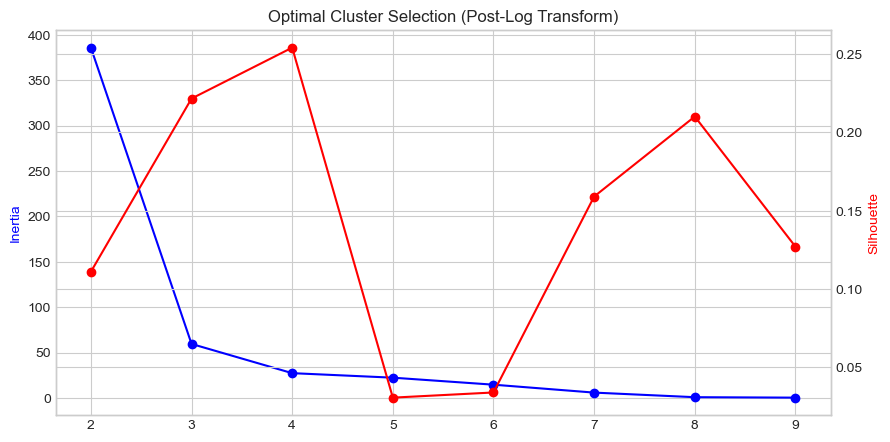


🏆 Optimal k selected automatically: 4

Cluster Profiles (Log-Adjusted):

         aid_volatility  rolling_mean_3yr  rolling_std_3yr  \
cluster                                                      
0           3692482.560            12.998           13.002   
1           3342020.472            12.434           12.395   
2           4344985.094            12.000           12.158   
3           3329439.553            13.455           13.476   

         sector_growth_rate  agency_growth_rate  aid_concentration_index  \
cluster                                                                    
0                     0.141               0.692                    0.014   
1                     2.873               4.368                    0.012   
2                     0.103               0.077                    0.017   
3                    -0.024               0.001                    0.013   

         aid_diversity_index  top3_agency_share  total_sector_aid  \
cluster                    

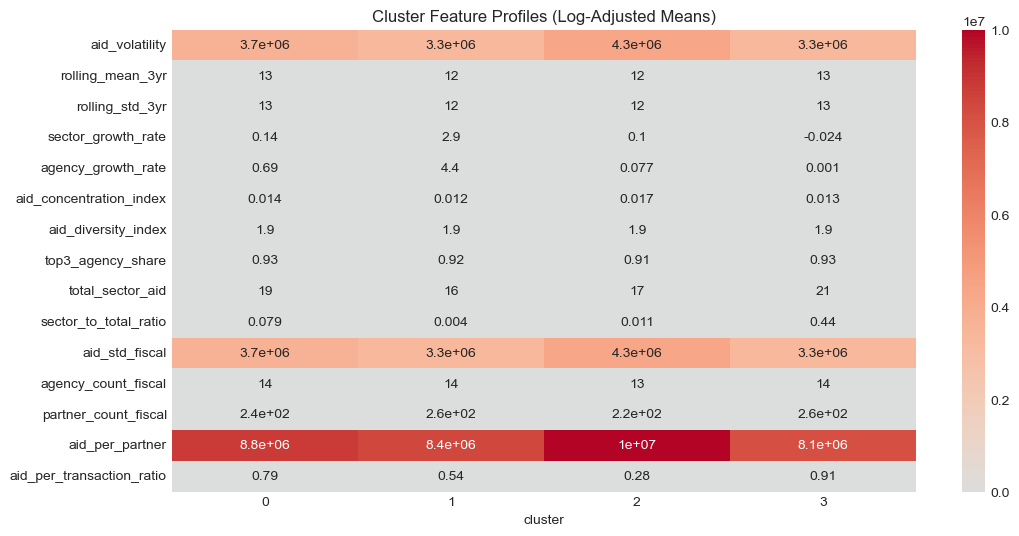

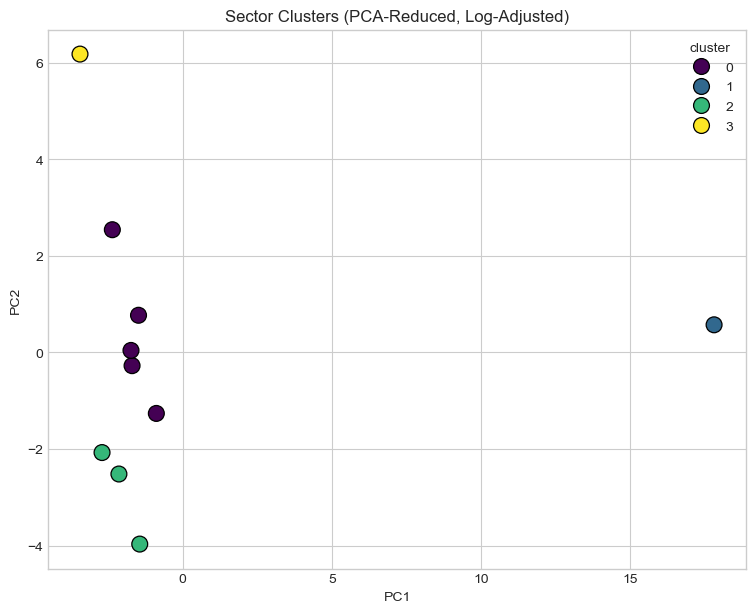


Cluster 0 (5 sectors):
Agriculture, Education, Human Rights, Other/Unspecified, Security

Cluster 1 (1 sectors):
Development

Cluster 2 (3 sectors):
Economy, Environment, Politics

Cluster 3 (1 sectors):
Health


In [ ]:
# Sector Clustering 
# -------------------------------

# Feature Set
cluster_features = [
    'aid_volatility', 'rolling_mean_3yr', 'rolling_std_3yr',
    'sector_growth_rate', 'agency_growth_rate',
    'aid_concentration_index', 'aid_diversity_index', 'top3_agency_share',
    'total_sector_aid', 'sector_to_total_ratio', 'aid_std_fiscal',
    'agency_count_fiscal', 'partner_count_fiscal',
    'aid_per_partner', 'aid_per_transaction_ratio'
]

# -------------------------------
# Aggregate & Clean
sector_df = (
    df.groupby('us_sector_name')[cluster_features]
    .mean()
    .reset_index()
    .dropna(subset=cluster_features)
)

# -------------------------------
# Detect Skewness Automatically
skew_threshold = 1.0  # log-transform if skewness > 1
skewness = sector_df[cluster_features].skew(numeric_only=True)

skewed_features = skewness[skewness > skew_threshold].index.tolist()

print(f"\nDetected Skewed Features (|skew| > {skew_threshold}):")
print(skewed_features)

# -------------------------------
# Apply Safe Log Transform
for col in skewed_features:
    sector_df[col] = np.log1p(sector_df[col])

# -------------------------------
# Scale Data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(sector_df[cluster_features])

# -------------------------------
# Evaluate Optimal K
results = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = model.fit_predict(X_scaled)
    results.append({
        'k': k,
        'inertia': model.inertia_,
        'silhouette': silhouette_score(X_scaled, labels),
        'calinski': calinski_harabasz_score(X_scaled, labels),
        'davies': davies_bouldin_score(X_scaled, labels)
    })

results_df = pd.DataFrame(results)
display(results_df)

# -------------------------------
# Visualize Cluster Evaluation
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(results_df['k'], results_df['inertia'], 'bo-', label='Inertia')
ax1.set_ylabel('Inertia', color='b')
ax2 = ax1.twinx()
ax2.plot(results_df['k'], results_df['silhouette'], 'ro-', label='Silhouette')
ax2.set_ylabel('Silhouette', color='r')
plt.title('Optimal Cluster Selection (Post-Log Transform)')
plt.xlabel('Number of Clusters (k)')
plt.show()

# -------------------------------
# Fit Final Model 
optimal_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']
print(f"\nOptimal k selected automatically: {int(optimal_k)}")

kmeans_final = KMeans(n_clusters=int(optimal_k), random_state=42, n_init='auto')
sector_df['cluster'] = kmeans_final.fit_predict(X_scaled)

# -------------------------------
# Cluster Profiles
cluster_summary = (
    sector_df.groupby('cluster')[cluster_features]
    .mean()
    .round(3)
)
print("\nCluster Profiles (Log-Adjusted):\n")
print(cluster_summary)

# -------------------------------
# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary.T, cmap='coolwarm', annot=True, center=0)
plt.title('Cluster Feature Profiles (Log-Adjusted Means)')
plt.show()

# -------------------------------
# PCA 
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)
sector_df['PC1'], sector_df['PC2'] = pca_coords[:, 0], pca_coords[:, 1]

plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=sector_df,
    x='PC1', y='PC2', hue='cluster', palette='viridis',
    s=130, edgecolor='black'
)
plt.title('Sector Clusters (PCA-Reduced, Log-Adjusted)')
plt.show()

# -------------------------------
# Sector Memberships
for c in sorted(sector_df['cluster'].unique()):
    members = sector_df[sector_df['cluster'] == c]['us_sector_name'].tolist()
    print(f"\nCluster {c} ({len(members)} sectors):")
    print(", ".join(members))

,k,inertia,silhouette,calinski,davies
0,2,198.944084,0.850791,407.979777,0.036491
1,3,66.357922,0.534245,542.117797,0.145654
2,4,35.168355,0.333130,586.289632,0.215109
3,5,16.735671,0.247419,771.395237,0.428256
4,6,12.032889,0.197261,686.954320,0.369263
5,7,3.464934,0.239639,1492.254123,0.275266
6,8,1.379657,0.174765,2141.983184,0.233396
7,9,0.250214,0.137179,5167.738960,0.096052


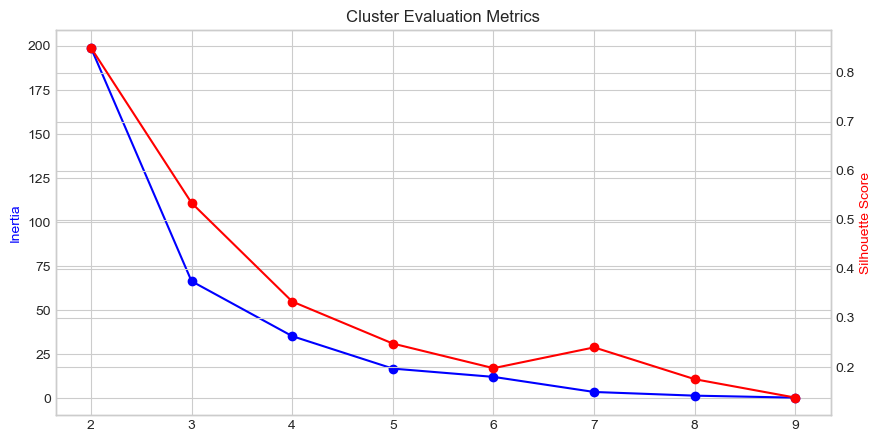


Cluster Profiles:

         aid_volatility  rolling_mean_3yr  rolling_std_3yr  \
cluster                                                      
0           3937171.010        464718.169       454337.263   
1           3342020.472        251118.297       241698.458   
2           3329439.553        697039.305       712157.189   

         sector_growth_rate  agency_growth_rate  aid_concentration_index  \
cluster                                                                    
0                     0.139               0.878                    0.015   
1                    16.697              77.905                    0.012   
2                    -0.024               0.001                    0.013   

         aid_diversity_index  top3_agency_share  total_sector_aid  \
cluster                                                             
0                      1.872              0.921      1.130532e+08   
1                      1.928              0.921      7.660699e+06   
2           

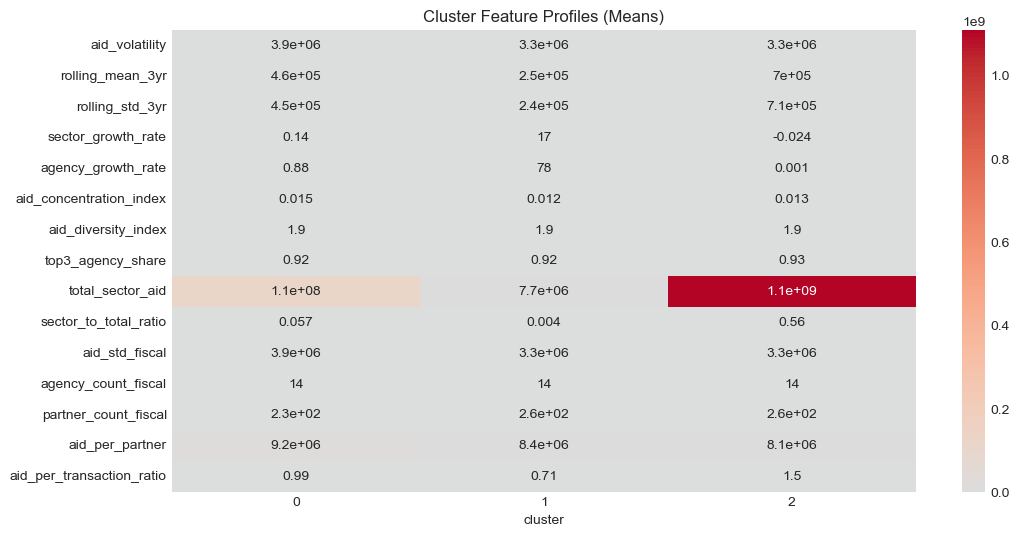

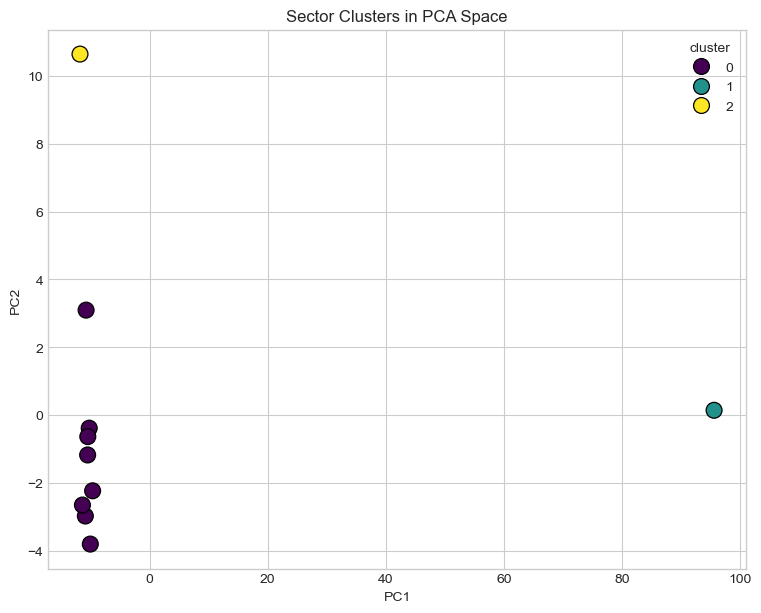


Cluster 0 (8 sectors):
Agriculture, Economy, Education, Environment, Human Rights, Other/Unspecified, Politics, Security

Cluster 1 (1 sectors):
Development

Cluster 2 (1 sectors):
Health


In [ ]:
# ===============================================================
# Sector Clustering 

# -------------------------------
# Feature Set
cluster_features = [
    'aid_volatility', 'rolling_mean_3yr', 'rolling_std_3yr',
    'sector_growth_rate', 'agency_growth_rate',
    'aid_concentration_index', 'aid_diversity_index', 'top3_agency_share',
    'total_sector_aid', 'sector_to_total_ratio', 'aid_std_fiscal',
    'agency_count_fiscal', 'partner_count_fiscal',
    'aid_per_partner', 'aid_per_transaction_ratio'
]

# -------------------------------
# Aggregate & Clean
sector_df = (
    df.groupby('us_sector_name')[cluster_features]
    .mean()
    .reset_index()
    .dropna(subset=cluster_features)
)

# -------------------------------
# Scale Features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(sector_df[cluster_features])

# -------------------------------
# Optimal Cluster Search
results = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = model.fit_predict(X_scaled)
    results.append({
        'k': k,
        'inertia': model.inertia_,
        'silhouette': silhouette_score(X_scaled, labels),
        'calinski': calinski_harabasz_score(X_scaled, labels),
        'davies': davies_bouldin_score(X_scaled, labels)
    })

results_df = pd.DataFrame(results)
display(results_df)

# Visualize Evaluation Metrics
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(results_df['k'], results_df['inertia'], 'bo-', label='Inertia')
ax1.set_ylabel('Inertia', color='b')
ax2 = ax1.twinx()
ax2.plot(results_df['k'], results_df['silhouette'], 'ro-', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='r')
plt.title('Cluster Evaluation Metrics')
plt.xlabel('Number of Clusters (k)')
plt.show()

# -------------------------------
# Fit Final K-Means
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
sector_df['cluster'] = kmeans_final.fit_predict(X_scaled)

# -------------------------------
# Cluster Profiles
cluster_summary = (
    sector_df.groupby('cluster')[cluster_features]
    .mean()
    .round(3)
)
print("\nCluster Profiles:\n")
print(cluster_summary)

# -------------------------------
# Standardized Cluster Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary.T, annot=True, cmap='coolwarm', center=0)
plt.title('Cluster Feature Profiles (Means)')
plt.show()

# -------------------------------
# PCA for Visual Separation
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)
sector_df['PC1'], sector_df['PC2'] = pca_coords[:, 0], pca_coords[:, 1]

plt.figure(figsize=(9, 7))
sns.scatterplot(
    data=sector_df,
    x='PC1', y='PC2', hue='cluster', palette='viridis',
    s=130, edgecolor='black'
)
plt.title('Sector Clusters in PCA Space')
plt.show()

# -------------------------------
# Sector Members per Cluster
for c in sorted(sector_df['cluster'].unique()):
    members = sector_df[sector_df['cluster'] == c]['us_sector_name'].tolist()
    print(f"\nCluster {c} ({len(members)} sectors):")
    print(", ".join(members))

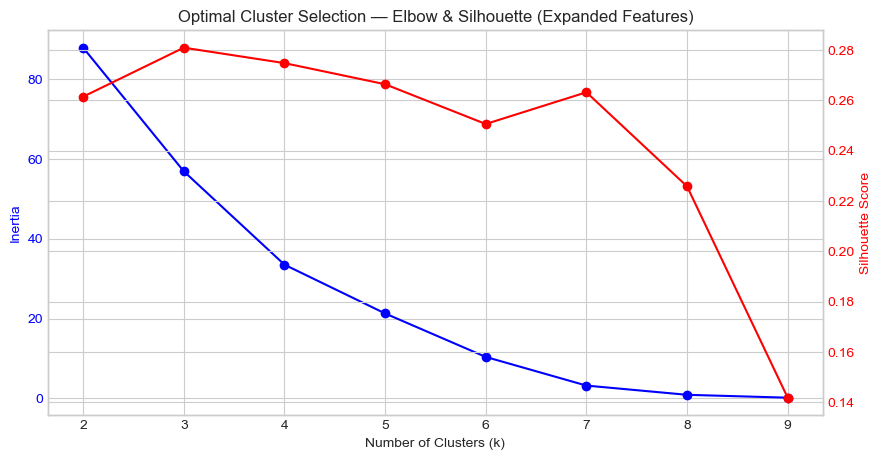


Cluster Profiles:

         aid_volatility  rolling_mean_3yr  rolling_std_3yr  \
cluster                                                      
0           3484355.314       1056255.671       965878.093   
1           3705785.431        451711.988       459489.409   
2           4344985.094        165141.787       192380.490   
3           3342020.472        251118.297       241698.458   

         sector_growth_rate  agency_growth_rate  aid_concentration_index  \
cluster                                                                    
0                     0.014               1.405                    0.013   
1                     0.180               0.993                    0.014   
2                     0.113               0.081                    0.017   
3                    16.697              77.905                    0.012   

         aid_diversity_index  top3_agency_share  total_sector_aid  \
cluster                                                             
0           

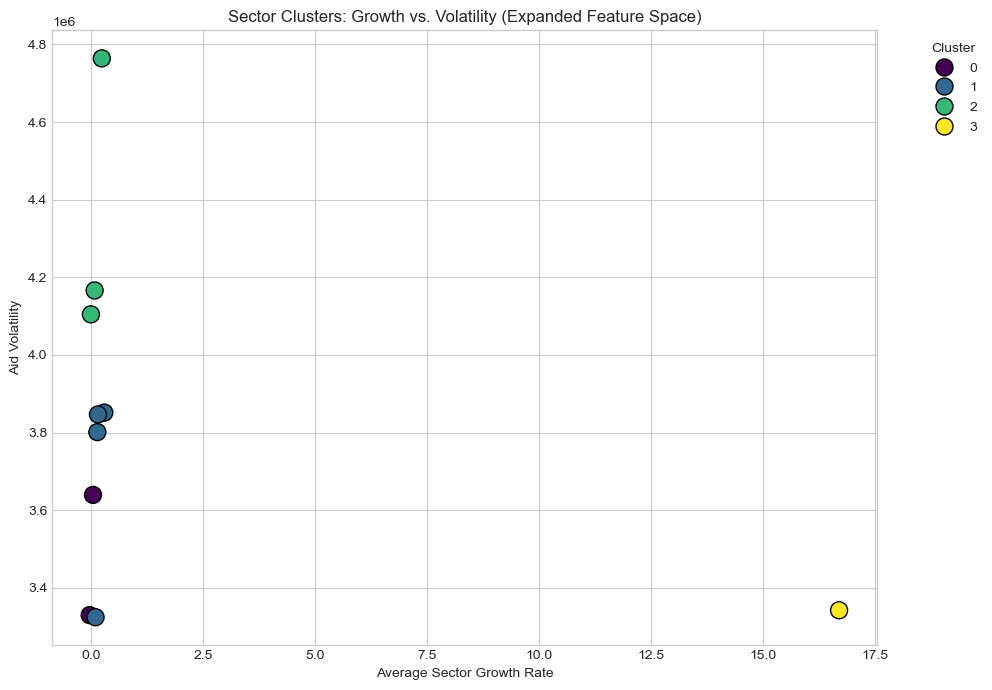


Cluster 0 (2 sectors):
Health, Human Rights

Cluster 1 (4 sectors):
Agriculture, Education, Other/Unspecified, Security

Cluster 2 (3 sectors):
Economy, Environment, Politics

Cluster 3 (1 sectors):
Development


In [ ]:
# Sector Clustering
# =======================

# Feature Set
cluster_features = [
    # Structural & Temporal Dynamics
    'aid_volatility', 'rolling_mean_3yr', 'rolling_std_3yr',

    # Growth & Trend Indicators
    'sector_growth_rate', 'agency_growth_rate',

    # Concentration & Diversity
    'aid_concentration_index', 'aid_diversity_index', 'top3_agency_share',

    # Scale & Magnitude
    'total_sector_aid', 'sector_to_total_ratio', 'aid_std_fiscal',

    # Institutional & Partner Breadth
    'agency_count_fiscal', 'partner_count_fiscal',

    # Efficiency Metrics 
    'aid_per_partner', 'aid_per_transaction_ratio'
]

# =======================
# Aggregate by Sector
sector_df = (
    df.groupby('us_sector_name')[cluster_features]
    .mean()
    .reset_index()
    .dropna(subset=cluster_features)
)

# =======================
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sector_df[cluster_features])

# =======================
# Determine Optimal K
inertia = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Elbow + Silhouette Visualization
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(K_range, inertia, 'bo-', label='Inertia')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_scores, 'ro-', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Optimal Cluster Selection — Elbow & Silhouette (Expanded Features)')
plt.show()

# =======================
# Fit Final Model
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
sector_df['cluster'] = kmeans_final.fit_predict(X_scaled)

# =======================
# Cluster Profiles
cluster_summary = (
    sector_df.groupby('cluster')[cluster_features]
    .mean()
    .round(3)
    .sort_index()
)
print("\nCluster Profiles:\n")
print(cluster_summary)

# =======================
# Visualize Clusters (Growth vs. Volatility)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=sector_df,
    x='sector_growth_rate',
    y='aid_volatility',
    hue='cluster',
    palette='viridis',
    s=150, edgecolor='black'
)
plt.title('Sector Clusters: Growth vs. Volatility (Expanded Feature Space)')
plt.xlabel('Average Sector Growth Rate')
plt.ylabel('Aid Volatility')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# =======================
# Sector Members per Cluster
for c in sorted(sector_df['cluster'].unique()):
    sectors = sector_df[sector_df['cluster'] == c]['us_sector_name'].tolist()
    print(f"\nCluster {c} ({len(sectors)} sectors):")
    print(", ".join(sectors))

Sectors:   0%|          | 0/10 [00:00<?, ?it/s]

22:29:43 - cmdstanpy - INFO - Chain [1] start processing
22:29:43 - cmdstanpy - INFO - Chain [1] done processing


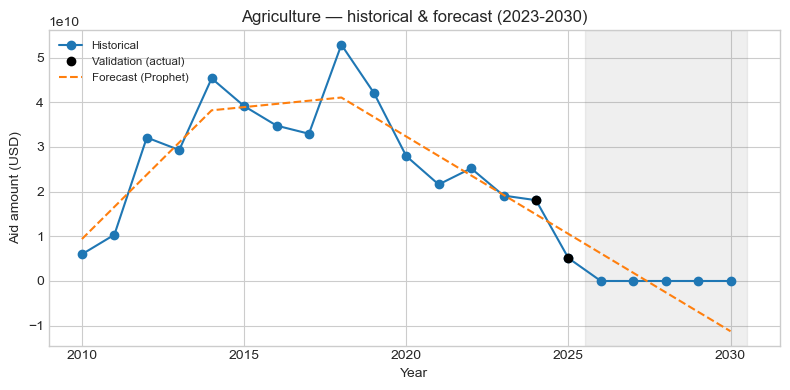

Sectors:  10%|█         | 1/10 [00:00<00:07,  1.25it/s]22:29:43 - cmdstanpy - INFO - Chain [1] start processing
22:29:43 - cmdstanpy - INFO - Chain [1] done processing


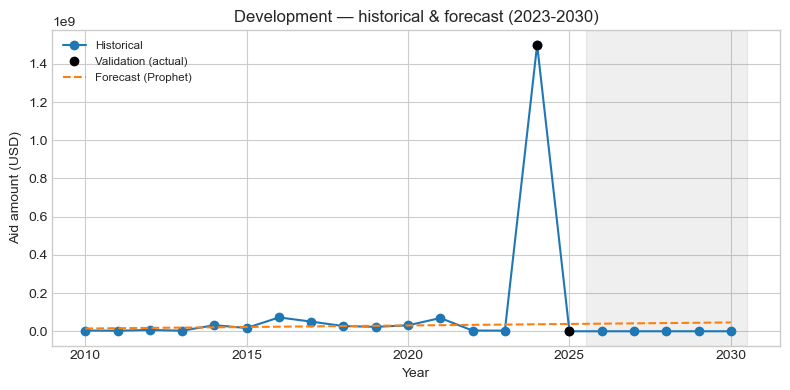

Sectors:  20%|██        | 2/10 [00:01<00:05,  1.34it/s]22:29:44 - cmdstanpy - INFO - Chain [1] start processing
22:29:44 - cmdstanpy - INFO - Chain [1] done processing


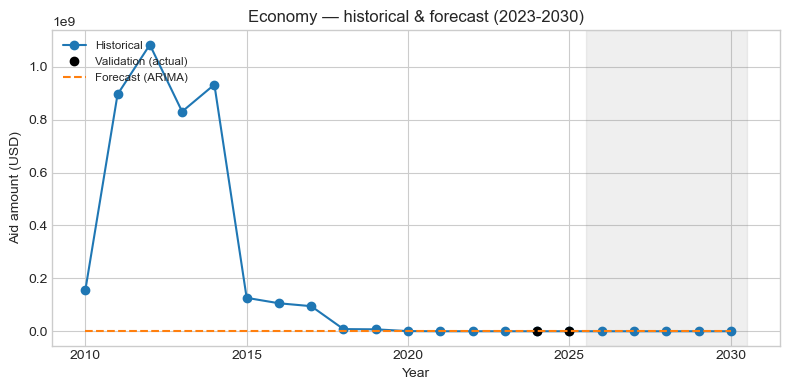

Sectors:  30%|███       | 3/10 [00:02<00:05,  1.37it/s]22:29:45 - cmdstanpy - INFO - Chain [1] start processing
22:29:45 - cmdstanpy - INFO - Chain [1] done processing


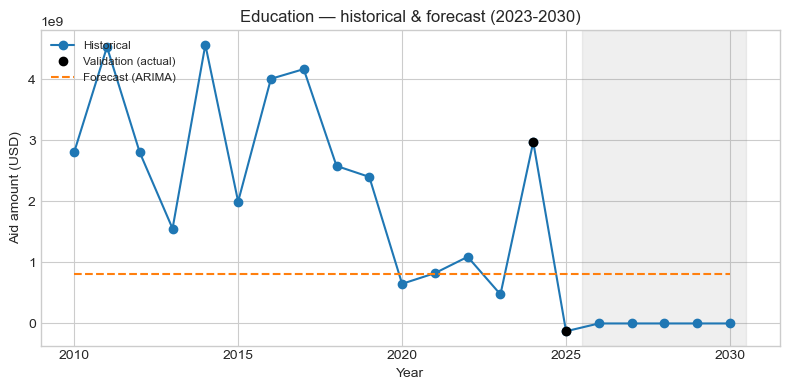

Sectors:  40%|████      | 4/10 [00:02<00:04,  1.42it/s]22:29:45 - cmdstanpy - INFO - Chain [1] start processing
22:29:46 - cmdstanpy - INFO - Chain [1] done processing


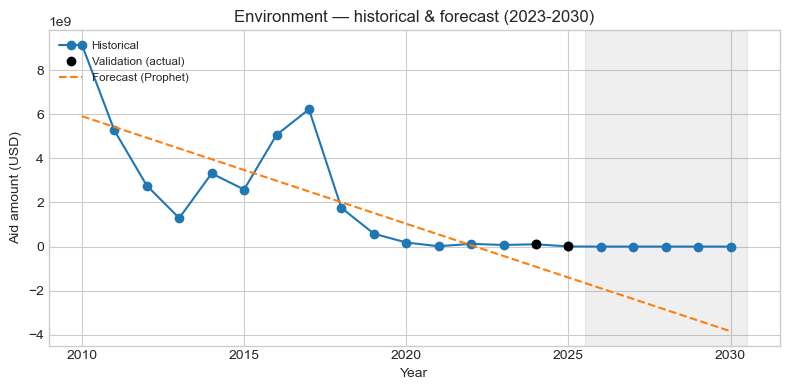

Sectors:  50%|█████     | 5/10 [00:03<00:03,  1.42it/s]22:29:46 - cmdstanpy - INFO - Chain [1] start processing
22:29:46 - cmdstanpy - INFO - Chain [1] done processing


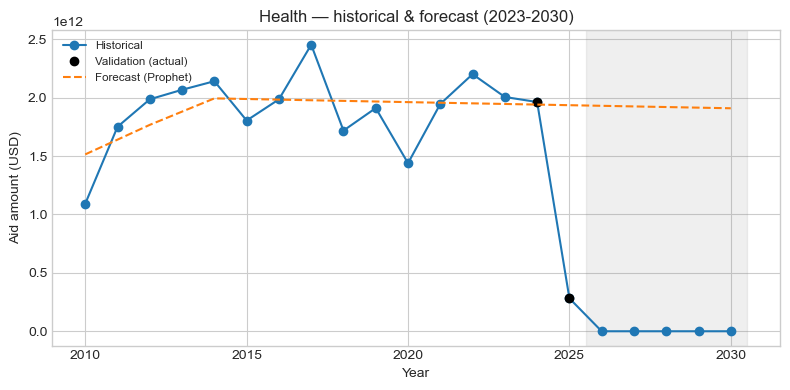

Sectors:  60%|██████    | 6/10 [00:04<00:02,  1.41it/s]22:29:47 - cmdstanpy - INFO - Chain [1] start processing
22:29:47 - cmdstanpy - INFO - Chain [1] done processing


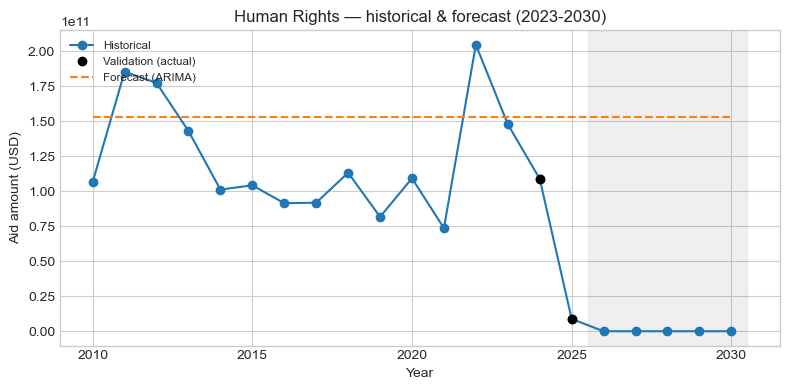

Sectors:  70%|███████   | 7/10 [00:04<00:02,  1.43it/s]22:29:48 - cmdstanpy - INFO - Chain [1] start processing
22:29:48 - cmdstanpy - INFO - Chain [1] done processing


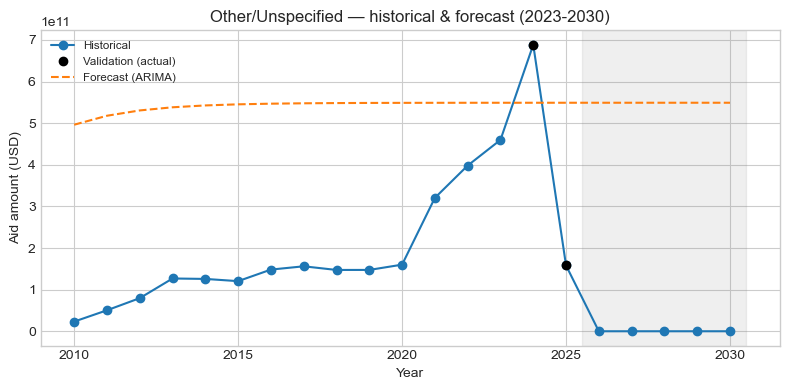

Sectors:  80%|████████  | 8/10 [00:05<00:01,  1.44it/s]22:29:48 - cmdstanpy - INFO - Chain [1] start processing
22:29:48 - cmdstanpy - INFO - Chain [1] done processing


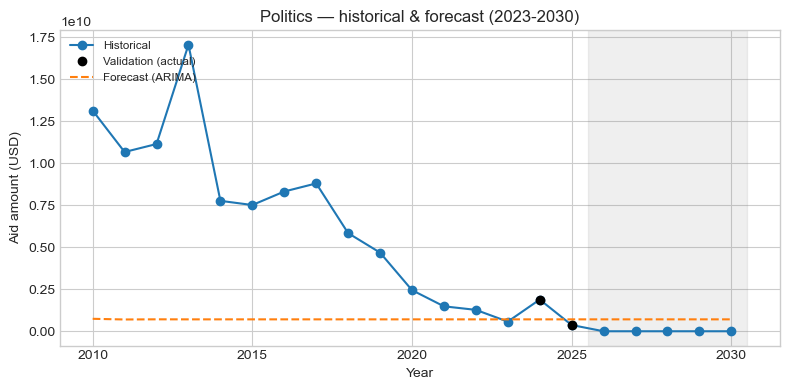

Sectors:  90%|█████████ | 9/10 [00:06<00:00,  1.41it/s]22:29:49 - cmdstanpy - INFO - Chain [1] start processing
22:29:49 - cmdstanpy - INFO - Chain [1] done processing


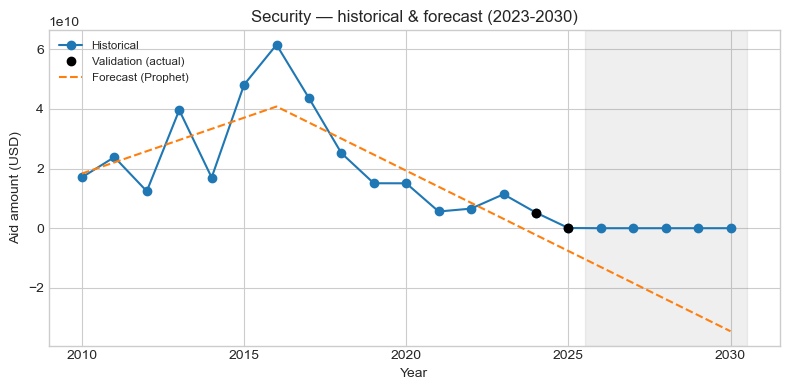

Sectors: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Model selection summary (per sector):
              sector best_model  prophet_rmse    arima_rmse
2            Economy      ARIMA  2.677956e+08  4.182546e+03
3          Education      ARIMA  1.857037e+09  1.665033e+09
6       Human Rights      ARIMA  1.143950e+11  1.065254e+11
7  Other/Unspecified      ARIMA  3.693181e+11  2.934883e+11
8           Politics      ARIMA  2.596399e+09  8.654689e+08
0        Agriculture    Prophet  4.447044e+09  1.020229e+10
1        Development    Prophet  1.035351e+09  1.048050e+09
4        Environment    Prophet  1.229167e+09  1.342740e+09
5             Health    Prophet  1.169647e+12  1.211973e+12
9           Security    Prophet  7.598068e+09  8.214679e+09

Sample forecast rows (first 20):
         sector  year  baseline_forecast     cut_20pct  rebound_10pct  \
0   Agriculture  2026       6.188718e+09  4.950975e+09   6.807590e+09   
1   Agriculture  2027       1.830775e+09  1.464620e+09   2.013853e+09   
2   Agriculture  2028       0.000000e+00  0.0000

In [ ]:
# Configuration
SEED = 42
TRAIN_END = 2023
VAL_START = 2024
VAL_END = 2025
FORECAST_START = 2026
FORECAST_END = 2030
TARGET = 'total_sector_aid'   # target to forecast; change if you prefer 'constant_dollar_amount'

# -------------------------
# Helper metrics
def mape(y_true, y_pred):
    # handle zero denominators gracefully
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(np.abs(y_true) < 1e-9, 1e-9, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

# -------------------------
# Prepare sector-year series
# -------------------------
# Aggregate by sector and fiscal year (mean / sum depending on column)
# Ensure we have a column 'fiscal_year' or 'transaction_year' as years in integers

if 'fiscal_year' in df.columns:
    year_col = 'fiscal_year'
elif 'transaction_year' in df.columns:
    year_col = 'transaction_year'
else:
    # attempt to extract year from transaction_date
    df[ 'transaction_date' ] = pd.to_datetime(df['transaction_date'])
    df['transaction_year'] = df['transaction_date'].dt.year
    year_col = 'transaction_year'

# Aggregate: sum total sector aid per sector-year (customize if your target is different)
agg = (
    df.groupby(['us_sector_name', year_col])[TARGET]
    .sum()
    .reset_index()
    .rename(columns={year_col: 'year', 'us_sector_name': 'sector', TARGET: 'value'})
)

# Keep years 2010 onwards if present
agg = agg[agg['year'] >= 2010].copy()

# List sectors
sectors = sorted(agg['sector'].unique())

# -------------------------
# Forecast storage
all_forecasts = []
metrics_list = []

# -------------------------
# Forecast loop per sector
for sector in tqdm(sectors, desc='Sectors'):
    s_df = agg[agg['sector'] == sector].sort_values('year').copy()
    # need a continuous yearly index; reindex to fill missing years with 0 or NaN
    years = list(range(int(s_df['year'].min()), int(max(s_df['year'].max(), FORECAST_END)) + 1))
    full = pd.DataFrame({'year': years})
    full = full.merge(s_df[['year', 'value']], on='year', how='left')
    # If large gaps, we still proceed; Prophet and ARIMA can handle NaNs if we fill/transform
    # Replace NaN with 0 for total aid (interpretable as no recorded funds) — adjust if not desired
    full['value'] = full['value'].fillna(0.0)

    # Split train / val
    train = full[full['year'] <= TRAIN_END].copy()
    val = full[(full['year'] >= VAL_START) & (full['year'] <= VAL_END)].copy()

    # If training series too short, skip
    if len(train) < 6:
        # not enough history for robust TS modeling
        metrics_list.append({
            'sector': sector,
            'prophet_rmse': np.nan,
            'arima_rmse': np.nan,
            'best_model': None
        })
        continue

    # ----- Prophet -----
    try:
        # Prophet requires ds & y
        prophet_df = train[['year', 'value']].rename(columns={'year':'ds', 'value':'y'})
        # convert ds to datetime for Prophet: use mid-year date
        prophet_df['ds'] = pd.to_datetime(prophet_df['ds'].astype(int).astype(str) + '-07-01')
        m = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
        # add a changepoint prior to allow reasonable trend flexibility
        m = Prophet(yearly_seasonality=False, changepoint_prior_scale=0.5)
        m.fit(prophet_df)

        # Build future frame for val + forecast horizon
        future_years = list(range(train['year'].min(), FORECAST_END + 1))
        future = pd.DataFrame({'ds': pd.to_datetime(pd.Series(future_years).astype(str) + '-07-01')})
        prophet_forecast = m.predict(future)
        # extract numeric year index and predictions
        prophet_forecast['year'] = prophet_forecast['ds'].dt.year
        pf = prophet_forecast[['year', 'yhat']].set_index('year')['yhat']

        # Validation predictions
        val_years = val['year'].values
        prophet_val_preds = pf.reindex(val_years).values
        # If some years missing, fill with 0
        prophet_val_preds = np.nan_to_num(prophet_val_preds, nan=0.0)

        prophet_rmse = rmse(val['value'].values, prophet_val_preds)
        prophet_mae = mean_absolute_error(val['value'].values, prophet_val_preds)
        prophet_r2 = r2_score(val['value'].values, prophet_val_preds) if len(val) > 1 else np.nan
        prophet_mape = mape(val['value'].values, prophet_val_preds)
    except Exception as e:
        prophet_rmse = np.nan
        prophet_mae = np.nan
        prophet_r2 = np.nan
        prophet_mape = np.nan
        pf = pd.Series(dtype=float)
    
    # ----- ARIMA  -----
    try:
        # Use simple auto ARIMA heuristics: try a few (p,d,q) combos and pick best AIC
        ts_train = train.set_index('year')['value']
        best_aic = np.inf
        best_order = None
        best_arima = None

        orders_to_try = [(1,0,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1),(2,0,2)]
        for order in orders_to_try:
            try:
                model = ARIMA(ts_train, order=order).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = order
                    best_arima = model
            except Exception:
                continue

        if best_arima is None:
            raise ValueError("ARIMA failed for sector")

        # Forecast from start of train to FORECAST_END
        arima_forecast = best_arima.get_forecast(steps=(FORECAST_END - train['year'].min() + 1))
        # Build index years matching forecast
        forecast_index = list(range(int(train['year'].min()), FORECAST_END + 1))
        arima_preds = pd.Series(arima_forecast.predicted_mean.values, index=forecast_index)

        # Validation preds
        val_years = val['year'].values
        arima_val_preds = arima_preds.reindex(val_years).values
        arima_val_preds = np.nan_to_num(arima_val_preds, nan=0.0)

        arima_rmse = rmse(val['value'].values, arima_val_preds)
        arima_mae = mean_absolute_error(val['value'].values, arima_val_preds)
        arima_r2 = r2_score(val['value'].values, arima_val_preds) if len(val) > 1 else np.nan
        arima_mape = mape(val['value'].values, arima_val_preds)
    except Exception as e:
        arima_rmse = np.nan
        arima_mae = np.nan
        arima_r2 = np.nan
        arima_mape = np.nan
        arima_preds = pd.Series(dtype=float)

    # ----- Select best model by RMSE -----
    # If both nan, skip selection
    if np.isnan(prophet_rmse) and np.isnan(arima_rmse):
        best_model = None
    else:
        # handle NaN by favoring the non-NaN
        if np.isnan(prophet_rmse):
            best_model = 'ARIMA'
        elif np.isnan(arima_rmse):
            best_model = 'Prophet'
        else:
            best_model = 'Prophet' if prophet_rmse <= arima_rmse else 'ARIMA'

    # ----- Build final forecast for 2026-2030 using best model -----
    # Compose a forecast series indexed by year for the full horizon
    if best_model == 'Prophet' and not pf.empty:
        forecast_series = pf.reindex(range(train['year'].min(), FORECAST_END + 1)).fillna(0.0)
    elif best_model == 'ARIMA' and not arima_preds.empty:
        forecast_series = arima_preds.reindex(range(train['year'].min(), FORECAST_END + 1)).fillna(0.0)
    else:
        # fallback: simple last-known-value persistence
        last_val = train['value'].iloc[-1] if len(train) > 0 else 0.0
        forecast_series = pd.Series([last_val] * (FORECAST_END - train['year'].min() + 1),
                                    index=range(train['year'].min(), FORECAST_END + 1))

    # Extract forecast years 2026-2030
    fc_index = list(range(FORECAST_START, FORECAST_END + 1))
    fc_values = forecast_series.reindex(fc_index).values
    # If any negative predictions occur, floor at zero (aid cannot be negative)
    fc_values = np.where(fc_values < 0, 0.0, fc_values)

    # Scenario simulations
    # -20% persistent cut: multiply baseline forecast by 0.8 for each forecast year
    scenario_cut = fc_values * 0.8
    # +10% rebound: multiply baseline by 1.10
    scenario_rebound = fc_values * 1.10

    # Save metrics
    metrics_list.append({
        'sector': sector,
        'prophet_rmse': prophet_rmse,
        'prophet_mae': prophet_mae,
        'prophet_r2': prophet_r2,
        'prophet_mape': prophet_mape,
        'arima_rmse': arima_rmse,
        'arima_mae': arima_mae,
        'arima_r2': arima_r2,
        'arima_mape': arima_mape,
        'best_model': best_model
    })

    # Save forecasts
    for year, y_hat, cut, rebound in zip(fc_index, fc_values, scenario_cut, scenario_rebound):
        all_forecasts.append({
            'sector': sector,
            'year': int(year),
            'baseline_forecast': float(y_hat),
            'cut_20pct': float(cut),
            'rebound_10pct': float(rebound),
            'model_used': best_model
        })

    # Plotting per sector (concise)
    try:
        plt.figure(figsize=(8,4))
        # historical: full years up to 2025 if available
        hist_idx = full['year']
        plt.plot(hist_idx, full['value'], label='Historical', marker='o')
        # plot validation actuals
        plt.plot(val['year'], val['value'], 'o', label='Validation (actual)', color='black')
        # plot baseline forecast (from start of forecast_series)
        fs_years = list(forecast_series.index)
        plt.plot(fs_years, forecast_series.values, '--', label=f'Forecast ({best_model})')
        # highlight forecast horizon
        plt.axvspan(FORECAST_START - 0.5, FORECAST_END + 0.5, color='grey', alpha=0.12)
        plt.title(f"{sector} — historical & forecast ({TRAIN_END}-{FORECAST_END})")
        plt.xlabel('Year'); plt.ylabel('Aid amount (USD)')
        plt.legend(loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

# -------------------------
# Results: 

metrics_df = pd.DataFrame(metrics_list).sort_values('sector').reset_index(drop=True)
forecasts_df = pd.DataFrame(all_forecasts).sort_values(['sector','year']).reset_index(drop=True)

# Print summary of selected models
print("\nModel selection summary (per sector):")
print(metrics_df[['sector','best_model','prophet_rmse','arima_rmse']].sort_values('best_model'))

# Show forecasts for a sample sector
print("\nSample forecast rows (first 20):")
print(forecasts_df.head(20))

Total aid reduction: 18.72% after a 25% cut to top 3 agencies.


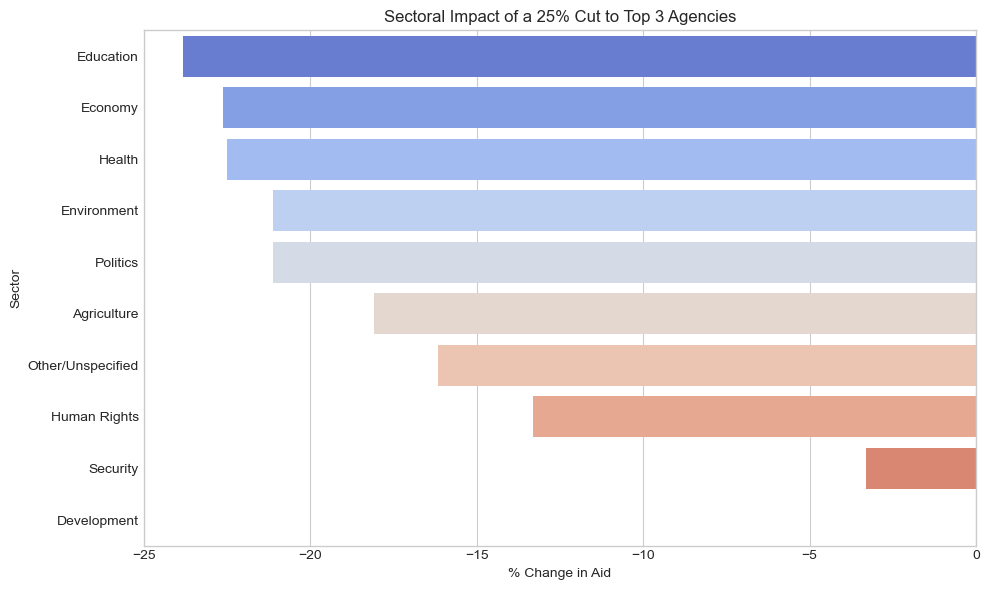

In [6]:
# --- 2. Simulate a 25% Cut to Top 3 Agencies ---

# Find top 3 agencies by total funding
top3_agencies = (
    df.groupby('managing_subagency_or_bureau_name')['constant_dollar_amount']
    .sum()
    .nlargest(3)
    .index
)

# Create a copy for scenario simulation
df_cut = df.copy()

# Apply 25% cut to top 3 agencies
df_cut.loc[df_cut['managing_subagency_or_bureau_name'].isin(top3_agencies), 'constant_dollar_amount'] *= 0.75

# Recalculate total aid and shares
baseline_total = df['constant_dollar_amount'].sum()
cut_total = df_cut['constant_dollar_amount'].sum()
impact_pct = 100 * (1 - cut_total / baseline_total)

print(f"Total aid reduction: {impact_pct:.2f}% after a 25% cut to top 3 agencies.")

# Recompute by sector and agency
agg_baseline = df.groupby('us_sector_name')['constant_dollar_amount'].sum().rename('baseline_aid')
agg_cut = df_cut.groupby('us_sector_name')['constant_dollar_amount'].sum().rename('post_cut_aid')

impact_df = pd.concat([agg_baseline, agg_cut], axis=1)
impact_df['change_%'] = 100 * (impact_df['post_cut_aid'] - impact_df['baseline_aid']) / impact_df['baseline_aid']
impact_df = impact_df.sort_values('change_%')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=impact_df.reset_index(), x='change_%', y='us_sector_name', palette='coolwarm')
plt.title('Sectoral Impact of a 25% Cut to Top 3 Agencies')
plt.xlabel('% Change in Aid')
plt.ylabel('Sector')
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:         aid_volatility   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 2.540e+05
Date:                Fri, 31 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:21:28   Log-Likelihood:            -9.7895e+05
No. Observations:               68264   AIC:                         1.958e+06
Df Residuals:                   68259   BIC:                         1.958e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

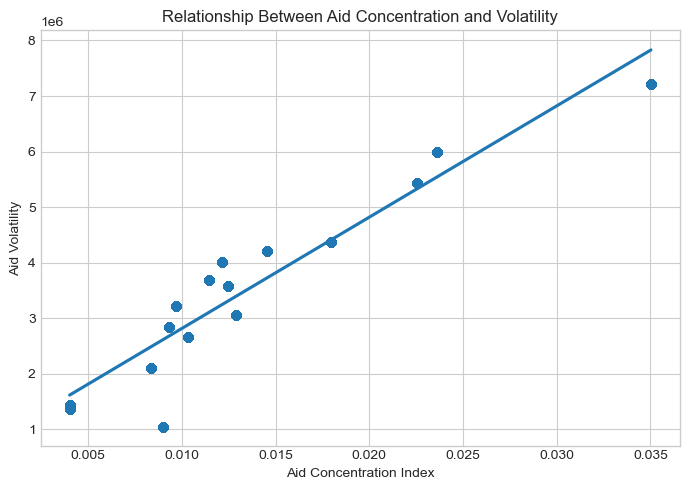

In [ ]:
# --- Analyze Volatility vs Concentration Relationship ---

# Prepare variables
analysis_df = df[['aid_volatility', 'aid_concentration_index', 'aid_diversity_index', 
                  'top3_agency_share', 'rolling_std_3yr']].dropna()

# Regression model
X = analysis_df[['aid_concentration_index', 'aid_diversity_index', 'top3_agency_share', 'rolling_std_3yr']]
y = analysis_df['aid_volatility']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

# Plot relationship (scatter with trend)
plt.figure(figsize=(7,5))
sns.regplot(data=analysis_df, x='aid_concentration_index', y='aid_volatility', scatter_kws={'alpha':0.4})
plt.title('Relationship Between Aid Concentration and Volatility')
plt.xlabel('Aid Concentration Index')
plt.ylabel('Aid Volatility')
plt.tight_layout()
plt.show()

Cluster Summary:
          aid_volatility  aid_concentration_index  aid_diversity_index
cluster                                                              
0          3.898679e+06                 0.014319             1.869138
1          2.081251e+06                 0.008062             1.962567
2          6.110460e+06                 0.024763             1.775228


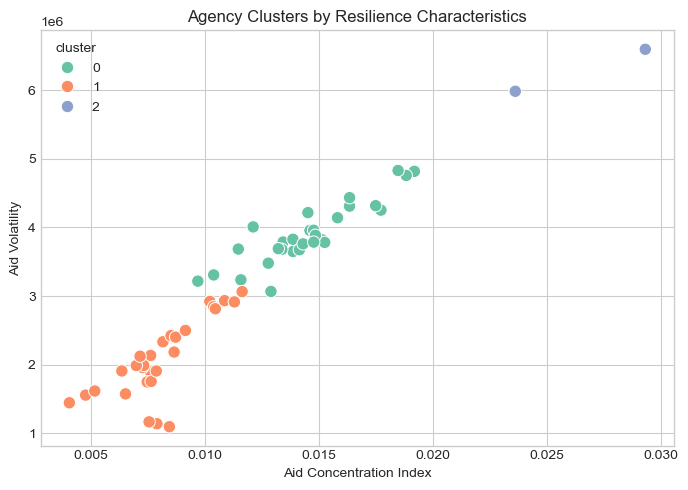

In [ ]:
# --- Cluster Agencies by Resilience Characteristics ---

# Compute agency-level aggregates
agency_features = (
    df.groupby('managing_subagency_or_bureau_name', as_index=False)
    [['aid_volatility', 'aid_concentration_index', 'aid_diversity_index', 'top3_agency_share']]
    .mean()
    .dropna()
)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(agency_features.drop(columns=['managing_subagency_or_bureau_name']))

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
agency_features['cluster'] = kmeans.fit_predict(X_scaled)

# Label clusters by average volatility
cluster_summary = agency_features.groupby('cluster')[['aid_volatility', 'aid_concentration_index', 'aid_diversity_index']].mean()
print("Cluster Summary:\n", cluster_summary)

# Visualization
plt.figure(figsize=(7,5))
sns.scatterplot(data=agency_features, x='aid_concentration_index', y='aid_volatility', hue='cluster', palette='Set2', s=80)
plt.title('Agency Clusters by Resilience Characteristics')
plt.xlabel('Aid Concentration Index')
plt.ylabel('Aid Volatility')
plt.tight_layout()
plt.show()

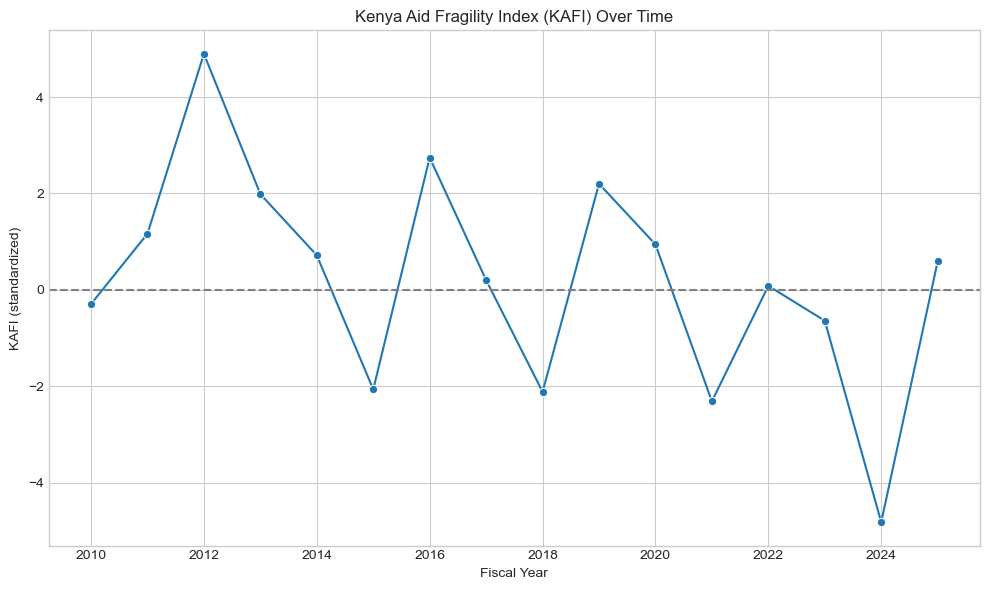

Most Fragile Years:
   fiscal_year      KAFI
2         2012  4.896270
6         2016  2.742188
9         2019  2.199921
3         2013  1.984949
1         2011  1.163667

Most Stable Years:
    fiscal_year      KAFI
14         2024 -4.823128
11         2021 -2.315445
8          2018 -2.118939
5          2015 -2.067485
13         2023 -0.643043


In [ ]:
# --- Compute Kenya Aid Fragility Index (KAFI) ---

# Normalize metrics
for col in ['aid_volatility', 'aid_concentration_index', 'aid_diversity_index', 'top3_agency_share']:
    df[f'{col}_z'] = (df[col] - df[col].mean()) / df[col].std()

# Construct KAFI (higher = more fragile)
df['KAFI'] = (
    df['aid_volatility_z'] +
    df['aid_concentration_index_z'] +
    df['top3_agency_share_z'] -
    df['aid_diversity_index_z']
)

# Aggregate by fiscal year
kafi_trend = df.groupby('fiscal_year')['KAFI'].mean().reset_index()

# Visualization
plt.figure(figsize=(10,6))
sns.lineplot(data=kafi_trend, x='fiscal_year', y='KAFI', marker='o')
plt.title('Kenya Aid Fragility Index (KAFI) Over Time')
plt.xlabel('Fiscal Year')
plt.ylabel('KAFI (standardized)')
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

# Inspect top and bottom years
print("Most Fragile Years:")
print(kafi_trend.sort_values('KAFI', ascending=False).head())

print("\nMost Stable Years:")
print(kafi_trend.sort_values('KAFI', ascending=True).head())

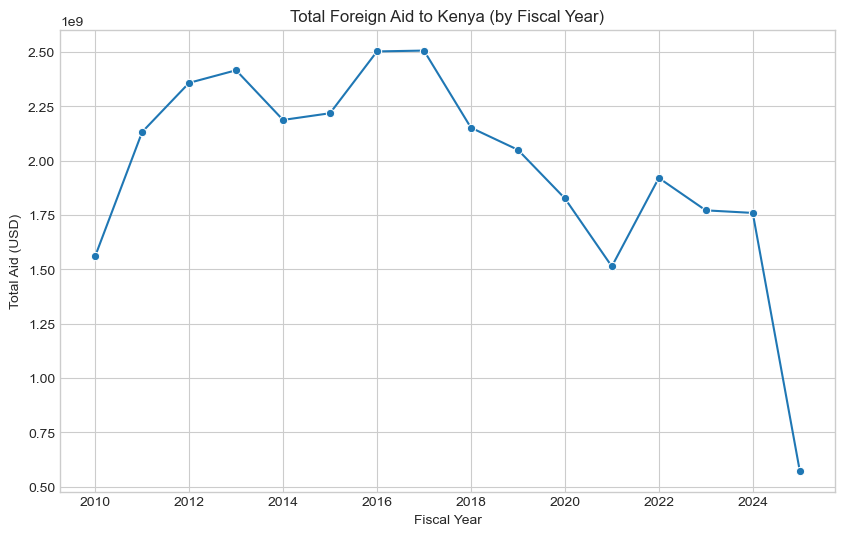

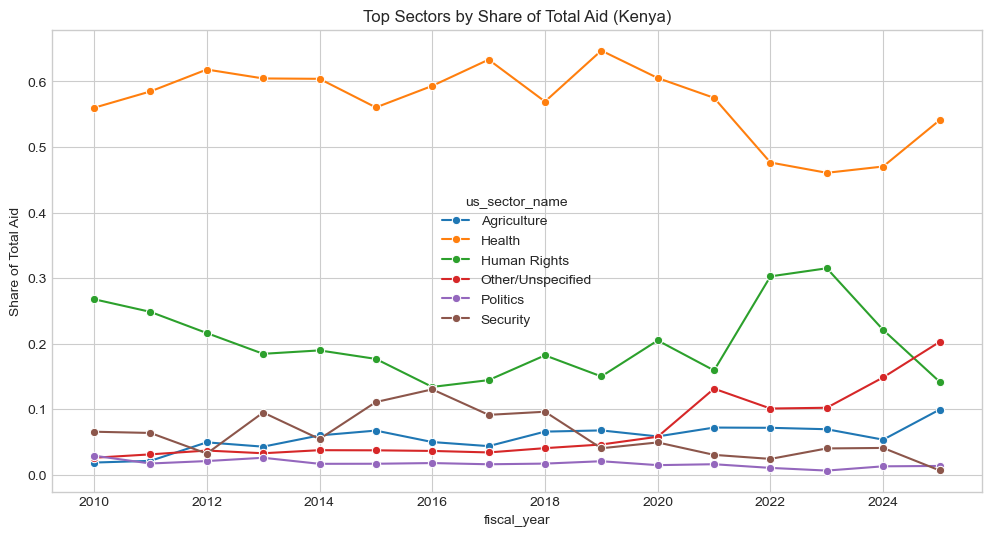

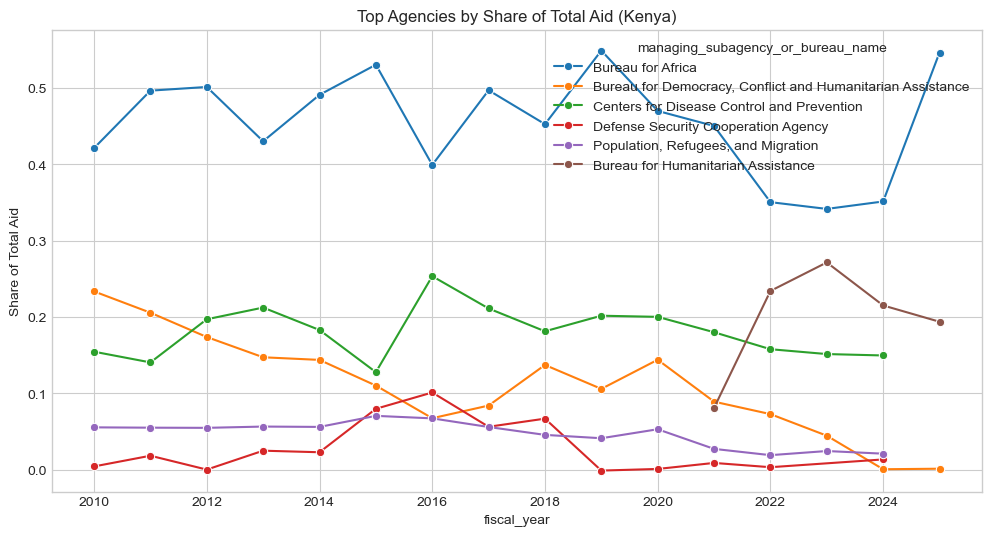

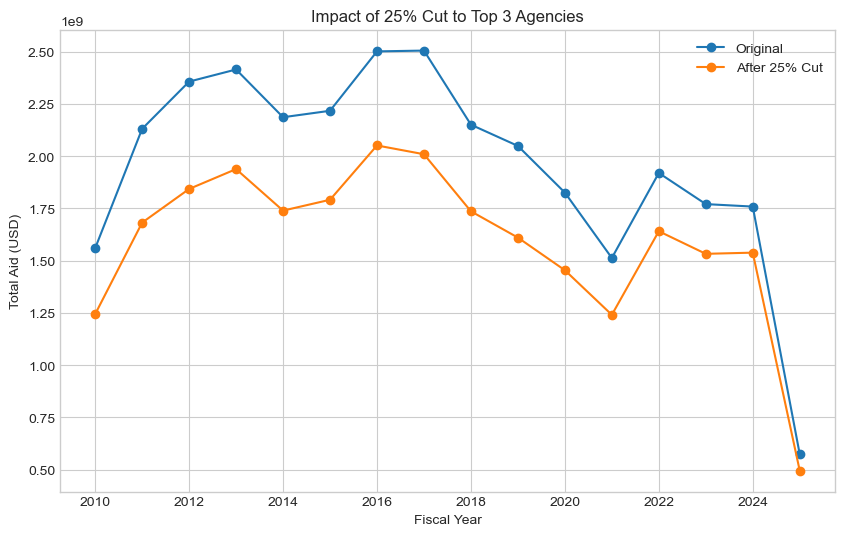


[Simulation] Top 3 agencies affected: Bureau for Africa, Centers for Disease Control and Prevention, Bureau for Democracy, Conflict and Humanitarian Assistance
Overall reduction: 18.72%


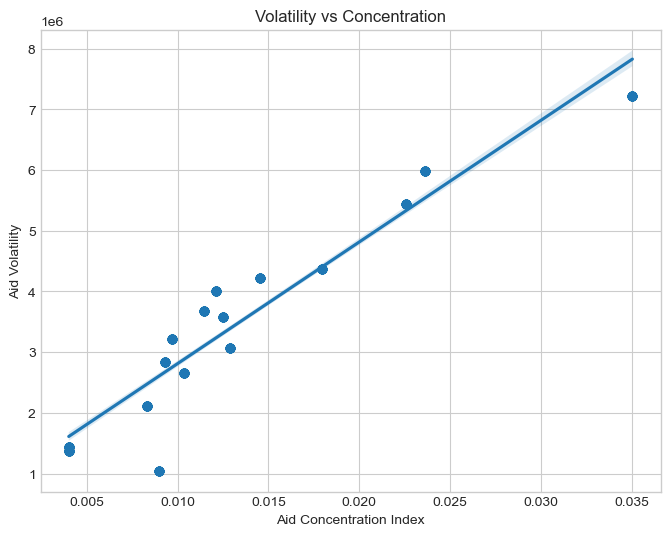

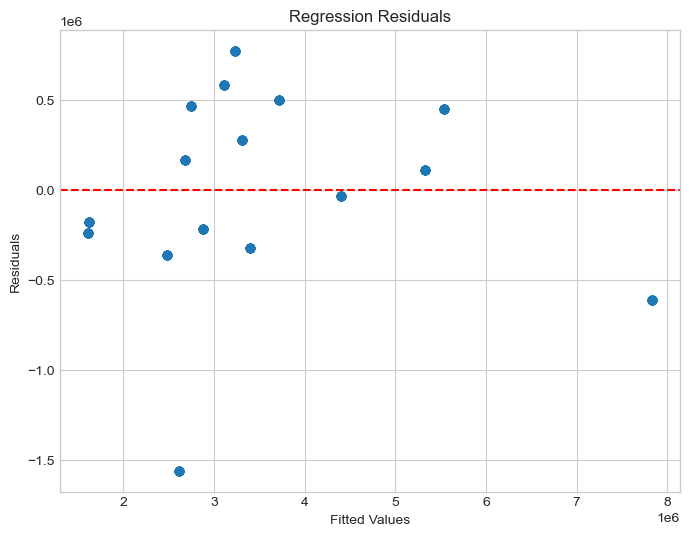

                            OLS Regression Results                            
Dep. Variable:         aid_volatility   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     4480.
Date:                Fri, 31 Oct 2025   Prob (F-statistic):          2.47e-252
Time:                        16:21:41   Log-Likelihood:                -7350.4
No. Observations:                 504   AIC:                         1.470e+04
Df Residuals:                     502   BIC:                         1.471e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                8

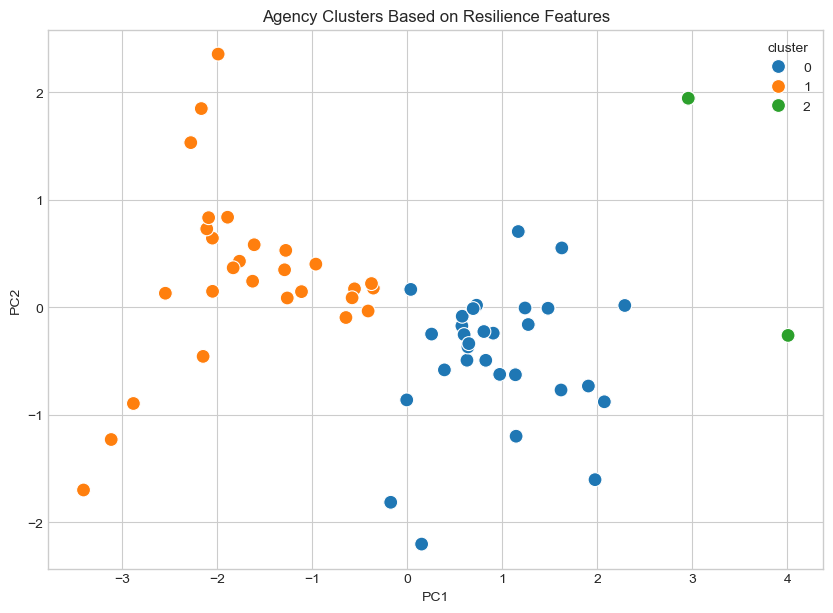


[Clustering Summary]
         avg_volatility  avg_concentration  avg_diversity  avg_top3_share  \
cluster                                                                     
0            3898679.35               0.01           1.87            0.92   
1            2081251.45               0.01           1.96            0.95   
2            6110459.73               0.02           1.78            0.95   

          PC1   PC2  
cluster              
0        0.93 -0.48  
1       -1.66  0.30  
2        3.17  1.50  

[Top 10 Most Fragile Agencies by KAFI]
managing_subagency_or_bureau_name
Democracy, Human Rights, and Labor                   100.0
Animal, Plant and Health Inspection Service          100.0
Patent and Trademark Office                          100.0
Federal Bureau of Investigation                      100.0
Bureau for Economic Growth, Agriculture and Trade     87.9
Trafficking in Persons                                69.5
Office of International and Tribal Affairs            

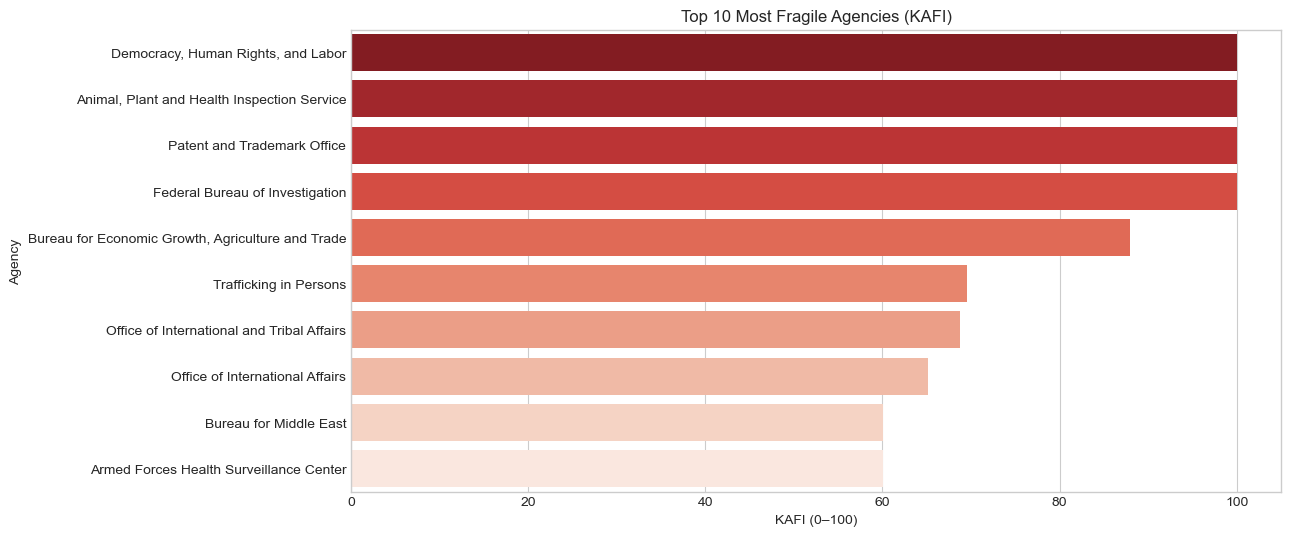

In [10]:
# ----------------------------------------------------------------------
# Aggregate & Visualize Aid Trends

def analyze_aggregates(df):
    AMOUNT = "constant_dollar_amount"
    FISCAL = "fiscal_year"
    SECTOR = "us_sector_name"
    AGENCY = "managing_subagency_or_bureau_name"

    # yearly totals
    total_by_year = df.groupby(FISCAL)[AMOUNT].sum().rename("total_aid")

    # sector breakdown
    agg_sector = (
        df.groupby([FISCAL, SECTOR])[AMOUNT]
        .sum()
        .rename("sector_aid")
        .reset_index()
        .merge(total_by_year, on=FISCAL)
    )
    agg_sector["sector_share"] = agg_sector["sector_aid"] / agg_sector["total_aid"]

    # agency breakdown
    agg_agency = (
        df.groupby([FISCAL, AGENCY])[AMOUNT]
        .sum()
        .rename("agency_aid")
        .reset_index()
        .merge(total_by_year, on=FISCAL)
    )
    agg_agency["agency_share"] = agg_agency["agency_aid"] / agg_agency["total_aid"]

    # ---- Plots ----
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=total_by_year.reset_index(), x=FISCAL, y="total_aid", marker="o")
    plt.title("Total Foreign Aid to Kenya (by Fiscal Year)")
    plt.ylabel("Total Aid (USD)")
    plt.xlabel("Fiscal Year")
    plt.show()

    # Top sectors & agencies
    top_sectors = agg_sector.groupby(SECTOR)["sector_share"].mean().nlargest(6).index
    top_agencies = agg_agency.groupby(AGENCY)["agency_share"].mean().nlargest(6).index

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=agg_sector[agg_sector[SECTOR].isin(top_sectors)],
        x=FISCAL, y="sector_share", hue=SECTOR, marker="o"
    )
    plt.title("Top Sectors by Share of Total Aid (Kenya)")
    plt.ylabel("Share of Total Aid")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=agg_agency[agg_agency[AGENCY].isin(top_agencies)],
        x=FISCAL, y="agency_share", hue=AGENCY, marker="o"
    )
    plt.title("Top Agencies by Share of Total Aid (Kenya)")
    plt.ylabel("Share of Total Aid")
    plt.show()

    return agg_sector, agg_agency, total_by_year


# ----------------------------------------------------------------------
# Simulate Aid Cuts

def simulate_aid_cut(df, cut_fraction=0.25, top_k=3):
    AMOUNT = "constant_dollar_amount"
    FISCAL = "fiscal_year"
    AGENCY = "managing_subagency_or_bureau_name"

    top_agencies = df.groupby(AGENCY)[AMOUNT].sum().nlargest(top_k).index
    df_sim = df.copy()
    df_sim["sim_amount"] = np.where(
        df_sim[AGENCY].isin(top_agencies),
        df_sim[AMOUNT] * (1 - cut_fraction),
        df_sim[AMOUNT],
    )

    baseline = df.groupby(FISCAL)[AMOUNT].sum()
    simulated = df_sim.groupby(FISCAL)["sim_amount"].sum()
    comparison = pd.DataFrame({
        "baseline": baseline,
        "after_cut": simulated,
    })
    comparison["pct_change"] = 100 * (comparison["after_cut"] / comparison["baseline"] - 1)

    # ---- Plot ----
    plt.figure(figsize=(10, 6))
    plt.plot(comparison.index, comparison["baseline"], label="Original", marker="o")
    plt.plot(comparison.index, comparison["after_cut"], label=f"After {int(cut_fraction*100)}% Cut", marker="o")
    plt.title(f"Impact of {int(cut_fraction*100)}% Cut to Top {top_k} Agencies")
    plt.xlabel("Fiscal Year")
    plt.ylabel("Total Aid (USD)")
    plt.legend()
    plt.show()

    # show summary
    print(f"\n[Simulation] Top {top_k} agencies affected: {', '.join(top_agencies)}")
    print(f"Overall reduction: {100 * (1 - simulated.sum() / baseline.sum()):.2f}%")

    return comparison, top_agencies


# ----------------------------------------------------------------------
# Regression: Volatility vs Concentration

def volatility_concentration_model(df):
    FISCAL = "fiscal_year"
    AGENCY = "managing_subagency_or_bureau_name"
    AMOUNT = "constant_dollar_amount"

    if "aid_volatility" not in df.columns:
        df["aid_volatility"] = df.groupby([AGENCY])[AMOUNT].transform(lambda x: x.pct_change().rolling(3).std())

    if "aid_concentration_index" not in df.columns:
        temp = df.groupby([FISCAL, AGENCY])[AMOUNT].sum().groupby(FISCAL)
        hhi = temp.apply(lambda d: (d / d.sum()) ** 2).sum(level=0)
        hhi = hhi.reset_index().rename(columns={AMOUNT: "aid_concentration_index"})
        df = df.merge(hhi, on=FISCAL, how="left")

    panel = (
        df.groupby([FISCAL, AGENCY])
        .agg(aid_volatility=("aid_volatility", "mean"),
             aid_concentration_index=("aid_concentration_index", "mean"))
        .dropna()
        .reset_index()
    )

    model = smf.ols("aid_volatility ~ aid_concentration_index", data=panel).fit()

    # ---- Plot regression ----
    plt.figure(figsize=(8, 6))
    sns.regplot(data=panel, x="aid_concentration_index", y="aid_volatility", scatter_kws={'alpha':0.6})
    plt.title("Volatility vs Concentration")
    plt.xlabel("Aid Concentration Index")
    plt.ylabel("Aid Volatility")
    plt.show()

    # residual plot
    plt.figure(figsize=(8, 6))
    plt.scatter(model.fittedvalues, model.resid, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title("Regression Residuals")
    plt.show()

    print(model.summary())
    return model, panel


# ----------------------------------------------------------------------
# Cluster Agencies by Resilience

def cluster_agencies(df, n_clusters=3):
    AGENCY = "managing_subagency_or_bureau_name"

    features = df.groupby(AGENCY).agg(
        avg_volatility=("aid_volatility", "mean"),
        avg_concentration=("aid_concentration_index", "mean"),
        avg_diversity=("aid_diversity_index", "mean"),
        avg_top3_share=("top3_agency_share", "mean"),
    ).fillna(0)

    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=25)
    features["cluster"] = km.fit_predict(X)

    # PCA projection for visualization
    pca = PCA(n_components=2, random_state=42)
    comps = pca.fit_transform(X)
    features["PC1"], features["PC2"] = comps[:, 0], comps[:, 1]

    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=features, x="PC1", y="PC2", hue="cluster", palette="tab10", s=100)
    plt.title("Agency Clusters Based on Resilience Features")
    plt.show()

    print("\n[Clustering Summary]")
    print(features.groupby("cluster").mean().round(2))

    return features


# ----------------------------------------------------------------------
# Kenya Aid Fragility Index (KAFI)
def compute_kafi(df):
    AGENCY = "managing_subagency_or_bureau_name"

    metrics = df.groupby(AGENCY).agg(
        volatility=("aid_volatility", "mean"),
        concentration=("aid_concentration_index", "mean"),
        diversity=("aid_diversity_index", "mean"),
        top3_share=("top3_agency_share", "mean"),
    ).fillna(0)

    z = (metrics - metrics.mean()) / metrics.std(ddof=0)
    metrics["KAFI"] = (
        z["volatility"] + z["concentration"] + z["top3_share"] - z["diversity"]
    )
    metrics["KAFI_0_100"] = 100 * (metrics["KAFI"] - metrics["KAFI"].min()) / (
        metrics["KAFI"].max() - metrics["KAFI"].min()
    )

    metrics = metrics.sort_values("KAFI_0_100", ascending=False)
    print("\n[Top 10 Most Fragile Agencies by KAFI]")
    print(metrics["KAFI_0_100"].head(10).round(1))

    plt.figure(figsize=(12, 6))
    sns.barplot(x=metrics["KAFI_0_100"].head(10),
                y=metrics.head(10).index,
                palette="Reds_r")
    plt.title("Top 10 Most Fragile Agencies (KAFI)")
    plt.xlabel("KAFI (0–100)")
    plt.ylabel("Agency")
    plt.show()

    return metrics


# ----------------------------------------------------------------------
# Run full analysis
agg_sector, agg_agency, total_by_year = analyze_aggregates(df)
comparison, top_agencies = simulate_aid_cut(df)
model, panel = volatility_concentration_model(df)
cluster_results = cluster_agencies(df)
kafi_scores = compute_kafi(df)